In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [21]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [23]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Data Manipulation

In [25]:

# Step 2: Create Binary Labels
# Assuming 'cyberbullying_type' has values like 'not_cyberbullying', 'gender', 'religion', etc.
def label_cyberbullying(row):
    if row['cyberbullying_type'] == 'not_cyberbullying':
        return -1
    else:  # For all other types (gender, religion, other_cyberbullying, age, ethnicity)
        return 1

df['label'] = df.apply(label_cyberbullying, axis=1)

# Step 3: Drop Unnecessary Columns
# You can keep 'tweet_text' and the new 'label' column
df_cleaned = df[['tweet_text', 'label']]

# Step 4: Save the Cleaned Data (optional)
df_cleaned.to_csv('cleaned_tweets.csv', index=False)

# Display the cleaned DataFrame
print(df_cleaned.head())

                                          tweet_text  label
0  In other words #katandandre, your food was cra...     -1
1  Why is #aussietv so white? #MKR #theblock #ImA...     -1
2  @XochitlSuckkks a classy whore? Or more red ve...     -1
3  @Jason_Gio meh. :P  thanks for the heads up, b...     -1
4  @RudhoeEnglish This is an ISIS account pretend...     -1


Checking for Unique Label

In [27]:
df=df_cleaned

In [29]:
df['label'].unique()

array([-1,  1], dtype=int64)

In [31]:
df.shape[0]

47692

Classification using pie chart 

In [33]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==-1].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.tight_layout()
    
    plt.show()

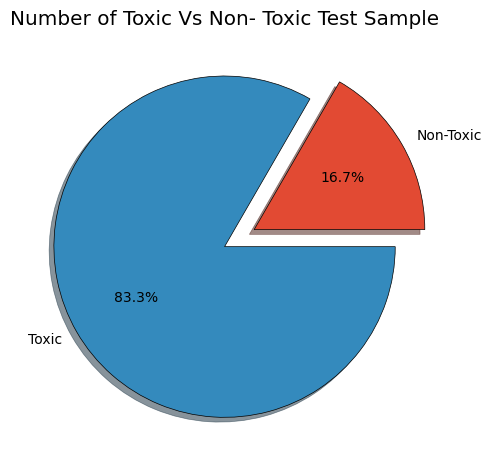

In [35]:
performdatadistribution(df)

In [37]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [39]:
df.head(1)

,tweet_text,label
0,"In other words #katandandre, your food was cra...",-1


In [41]:
def datasetCleaning(df):
    df['length_tweet_text'] = df['tweet_text'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)
#     remove @ user
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['tweet_text'], r"@[\w]*")
    
#     remove extra letters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
#      Remove '#' character
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("#", "", regex=False)
    
#     remove all those words with size less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))
    
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    
#     Tokenized
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x : x.split())
    
    nltk.download('wordnet')
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    tokenized_tweet = tokenized_tweet.apply(lambda x :[lemmatizer.lemmatize(i) for i in x])
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df, df

In [43]:
combined_df, df =datasetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
combined_df.head()

,tweet_text,label,length_tweet_text,tidy_tweet,length_tidy_tweet
0,"In other words #katandandre, your food was cra...",-1,61,"other word katandandre, your food crapilicious!",48
1,Why is #aussietv so white? #MKR #theblock #ImA...,-1,115,aussietv white? theblock ImACelebrityAU today ...,87
2,@XochitlSuckkks a classy whore? Or more red ve...,-1,60,classy whore? more velvet cupcakes?,35
3,"@Jason_Gio meh. :P thanks for the heads up, b...",-1,103,meh. thanks head concerned about another angry...,61
4,@RudhoeEnglish This is an ISIS account pretend...,-1,103,This ISIS account pretending Kurdish account. ...,63


Dataset  Splitting

In [47]:
from sklearn.model_selection import train_test_split

In [49]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [51]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 95384
Number of rows in the train dataset: 76307
Number of rows in the test dataset: 19077


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [53]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [55]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [57]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)
        
        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)
        
        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result

In [59]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training LinearSVC finished in 0.9221315383911133 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 0.8529055118560791 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.02100205421447754 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 26.43798518180847 sec
Training Time : AdaBoostClassifier


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoostClassifier finished in 8.96051836013794 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 292.75209188461304 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.16193222999572754 sec


In [61]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [63]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,BaggingClassifier,292.752092,1.607352,0.918488,0.966569,0.951502,0.980005,0.944988,0.976660,0.958106,0.983373
1,DecisionTreeClassifier,26.437985,0.135021,0.918593,0.968666,0.951245,0.981070,0.950916,0.987630,0.951573,0.974596
2,LinearSVC,0.922132,0.008541,0.908057,0.948445,0.946001,0.969545,0.927722,0.954559,0.965015,0.985009
3,LogisticRegression,0.852906,0.008706,0.884783,0.911673,0.933891,0.948977,0.896000,0.914688,0.975127,0.985937
4,MultinomialNB,0.021002,0.008993,0.867694,0.880404,0.926143,0.932790,0.866981,0.876999,0.993970,0.996162
5,SGDClassifier,0.161932,0.006958,0.859464,0.864036,0.921670,0.924058,0.861630,0.864150,0.990704,0.992890
6,AdaBoostClassifier,8.960518,1.773995,0.842638,0.843081,0.911571,0.911626,0.858324,0.858730,0.971861,0.971466


In [65]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.021002,0.006958,0.842638,0.843081,0.911571,0.911626,0.858324,0.85873,0.951573,0.971466
max,292.752092,1.773995,0.918593,0.968666,0.951502,0.981070,0.950916,0.98763,0.993970,0.996162


Summary IN Graph

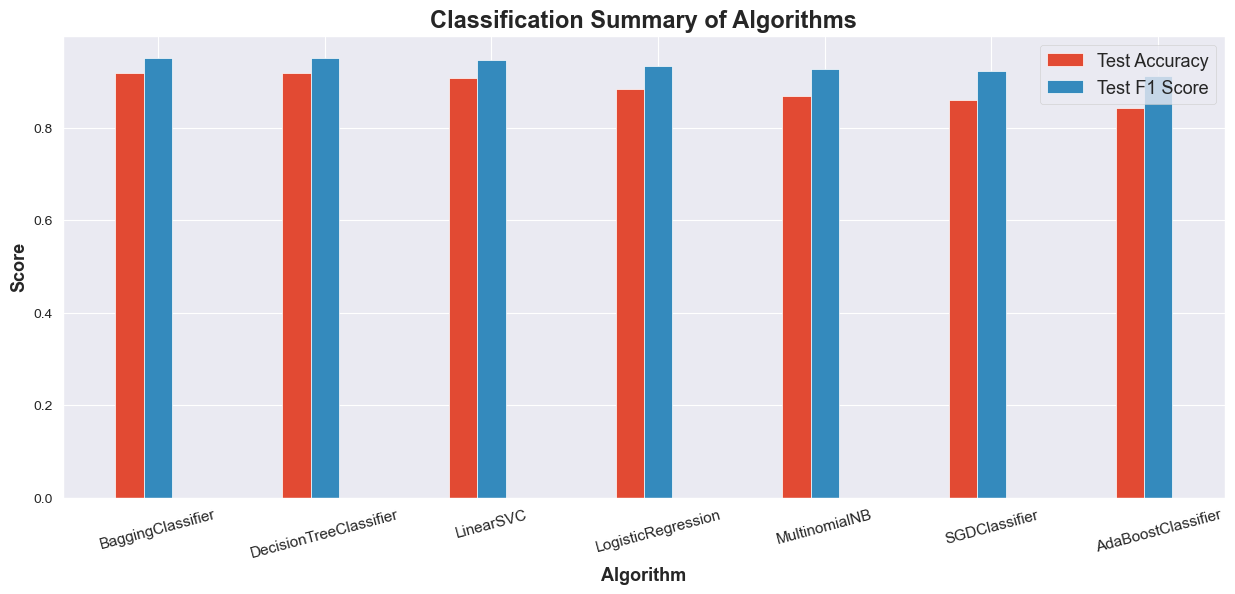

In [67]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

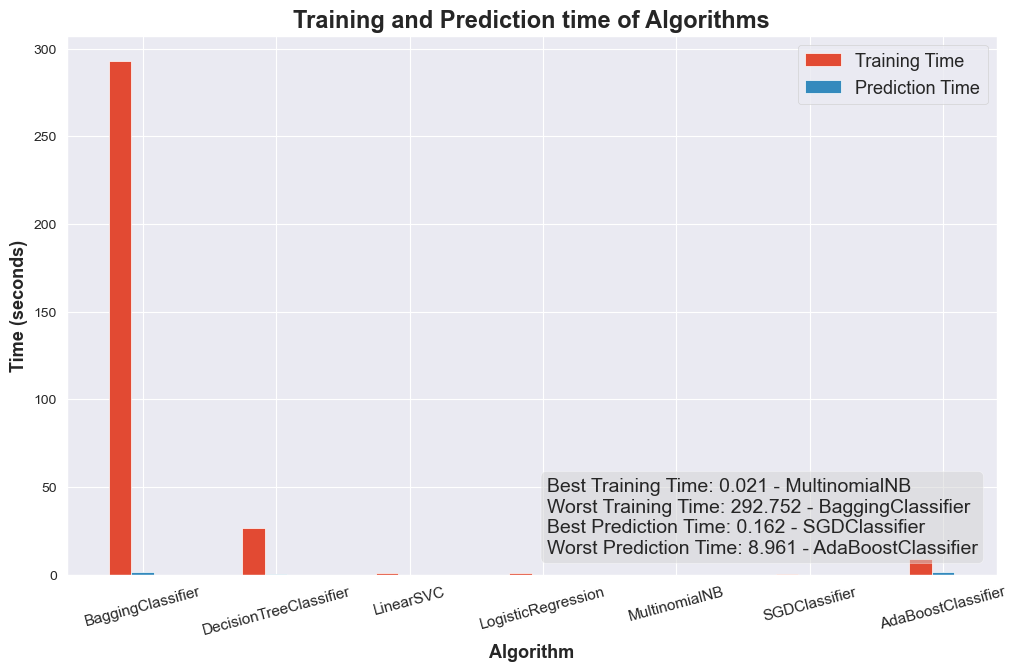

In [69]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [71]:
df.head()

,tweet_text,label,length_tweet_text
0,"In other words #katandandre, your food was cra...",-1,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,-1,115
2,@XochitlSuckkks a classy whore? Or more red ve...,-1,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",-1,103
4,@RudhoeEnglish This is an ISIS account pretend...,-1,103


In [73]:
data = ["You are so beautiful"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[-1]
non-bulling


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Fine Tuining

In [75]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [77]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_clas

LinearSVC
Best Parameter:  {'C': 1}
Accuracy:  0.9080568223515227
F1 Score :  0.9460008620158857
Precision :  0.9277217559326127
Recall:  0.9650147603793732


In [79]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))